In [1]:
import logging
import sys

import matplotlib.pyplot as plt

root = logging.getLogger()
root.setLevel(logging.INFO)

handler = logging.StreamHandler(sys.stdout)
handler.setLevel(logging.INFO)
formatter = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')
handler.setFormatter(formatter)
root.addHandler(handler)

In [2]:
import sys

sys.path.append('../scripts')
sys.path.append('../')
from scripts import centroids_graph_builder
from time import sleep
from multiprocessing import Pool
from scripts import dijkstra
import numpy as np
from tqdm.notebook import trange, tqdm
from scripts import graph_osm_loader, utils

import networkx as nx
from heapq import heappop, heappush
from itertools import count
from scripts import clustering

In [3]:
NUM_ITERATION = 5  # чтобы уменьшить ошибку при вычислении времени выполнения, при каждом замере время меряется для NUM_ITERATION повторений
WORKER = 10  # количество потоков

In [4]:
    # 'PARIS': 'R71525',
    # 'Prague': 'R435514',
    # 
    # 'DUBAI': 'R3766483',


In [5]:
GRAPH_ID = 'R71525'  # R13470549 R2555133 R3766483
# примеры id есть в graph_osm_loader.py
# g = get_rand_graph(1000, 0.1)  # зарузка графа
N = 10000
p = 3 / N
# g = get_rand_graph(N,p)
# g = get_graph()
g = graph_osm_loader.get_graph(GRAPH_ID)
print(len(g.nodes), len(g.edges))

9507 14804


In [6]:
g.remove_edges_from(nx.selfloop_edges(g))

In [7]:
cms = clustering.resolve_louvain_communities(g, resolution=26.5)
print(len(cms))

525


In [8]:
cls2n =  centroids_graph_builder.get_cls2n(g) # мапа кластер к соседним кластерам 
g1, cls2c = centroids_graph_builder.build_center_graph(g, cms, cls2n, log=True)

find edges: 100%|██████████| 525/525 [00:00<00:00, 1001.36it/s]


In [9]:
nodes = g.nodes()

In [10]:
a = 1

In [19]:
def dst(da,db):
    return ((da['x'] - db['x']) ** 2 + (da['y'] - db['y']) ** 2) ** 0.5 / 360 * 2 * np.pi * 6371.01 * 1000 * a

In [20]:
def node_dst(u,v):
    da = nodes[u]
    db = nodes[v]
    return dst(da,db)

In [21]:
for u,v,d in g.edges(data=True):
    a = min(a, d['length']/node_dst(u,v))
a

np.float64(0.7894150087507097)

In [22]:
# find path between two points
def find_path_length_h(
        g0: nx.Graph,
        g1: nx.Graph,
        cms: list[set[int]] | tuple[set[int]],
        cls2c: dict[int, int],
        from_node: int,
        to_node: int) -> float:
    from_cluster = g0.nodes()[from_node]['cluster']
    to_cluster = g0.nodes()[to_node]['cluster']
    
    def h(a, b):
        da = nodes[cls2c[a]]
        db = nodes[cls2c[b]]
        return dst(da,db)
    path = nx.single_source_dijkstra(g1, from_cluster, to_cluster, weight='length')[1]
    # path = nx.bidirectional_dijkstra(g1, from_cluster, to_cluster, weight='length')[1]
    # path = nx.astar_path(g1, from_cluster, to_cluster, weight='length', heuristic=h)
    
    cls = set([u for u in path])
    g = centroids_graph_builder.extract_cluster_list_subgraph(g0, cls, cms)
    return nx.single_source_dijkstra(g, from_node, to_node, weight='length')
    # return nx.bidirectional_dijkstra(g, from_node, to_node, weight='length')
    # return nx.astar_path_length(g, from_node, to_node, weight='length', heuristic=node_dst), []

In [23]:
# points = [(u,v) for u in g.nodes() for v in g.nodes() if u!=v]
# points = [utils.get_node_for_initial_graph_v2(g) for _ in trange(1000, desc='generate points')]

In [24]:
path = utils.get_path('pouits', f'points_{GRAPH_ID}.pickle')
import os
import pickle
if os.path.exists(path):
    with open(path, 'rb') as fp:
        points = pickle.load(fp)
        fp.close()
else:
    points = [utils.get_node_for_initial_graph_v2(g) for _ in trange(1000, desc='generate points')]
    with open(path, 'wb') as fp:
        pickle.dump(points, fp)
        fp.close()

In [25]:
@utils.profile(iterations=NUM_ITERATION)
def usual_path(g, p1, p2):
    return dijkstra.dijkstra_pfa(g, p1,p2)

@utils.profile(iterations=NUM_ITERATION)
def h_path(g, p1, p2):
    # return find_path_length_h(g,g1, cms, cls2c, p1, p2)
    # return nx.astar_path_length(g, p1, p2, weight='length', heuristic=node_dst), []
    return dijkstra.astar(g, p1,p2,node_dst)

def do_calc(data_partitions):
    point_partition, worker_number = data_partitions

    stat = {
        'l': [],
        'h_l': [],
        'p': [],
        'h_p': [],
        'time_l': [],
        'time_h': [],
        'delta': []
    }

    # чисто чтобы tqdm нормально прогрузился 
    sleep(worker_number / 10)
    print('start', worker_number)

    for p1, p2 in tqdm(
            point_partition,
            desc=f'find paths {worker_number}',
            position=worker_number
    ):
        # класический дейкстра
        time_l, (l, p) = usual_path(g, p1, p2)
        # иерархический
        time_h, (h_l, h_p) = h_path(g, p1, p2)
        delta = (h_l - l) / l * 100

        stat['l'].append(l)  # длина обычного пути
        stat['h_l'].append(h_l)  # длина иерархического пути
        stat['p'].append(p)  # обычный путь
        stat['h_p'].append(h_p)  # иерархический путь
        stat['delta'].append(delta)  # разница в длине
        stat['time_l'].append(time_l)  # обычное время 
        stat['time_h'].append(time_h)  # иерархическое
    return stat


data = [([p for p in points[i::WORKER]], i) for i in range(WORKER)]
# do_calc(data[0])
with Pool(WORKER) as p:
    stat = {k: v for r in p.imap_unordered(do_calc, data) for k, v in r.items()}

print(f"err_mean: {np.mean(stat['delta']):.2f} %")
print(f"err_min: {np.min(stat['delta']):.2f} %")
print(f"err_max: {np.max(stat['delta']):.2f} %", )
print(f"acceleration: {np.mean(np.array(stat['time_l']) / np.array(stat['time_h'])):.2f} times")

start 0


find paths 0:   0%|          | 0/100 [00:00<?, ?it/s]

start 1


find paths 1:   0%|          | 0/100 [00:00<?, ?it/s]

start 2


find paths 2:   0%|          | 0/100 [00:00<?, ?it/s]

start 3


find paths 3:   0%|          | 0/100 [00:00<?, ?it/s]

start 4


find paths 4:   0%|          | 0/100 [00:00<?, ?it/s]

start 5


find paths 5:   0%|          | 0/100 [00:00<?, ?it/s]

start 6


find paths 6:   0%|          | 0/100 [00:00<?, ?it/s]

start 7


find paths 7:   0%|          | 0/100 [00:00<?, ?it/s]

start 8


find paths 8:   0%|          | 0/100 [00:00<?, ?it/s]

start 9


find paths 9:   0%|          | 0/100 [00:00<?, ?it/s]

err_mean: 0.66 %
err_min: 0.00 %
err_max: 4.40 %
acceleration: 9.08 times


{'whiskers': [<matplotlib.lines.Line2D at 0x7ca368c59df0>,
 'caps': [<matplotlib.lines.Line2D at 0x7ca368c5a360>,
 'boxes': [<matplotlib.lines.Line2D at 0x7ca3698671d0>],
 'medians': [<matplotlib.lines.Line2D at 0x7ca368c5a900>],
 'fliers': [<matplotlib.lines.Line2D at 0x7ca368c5abd0>],
 'means': []}

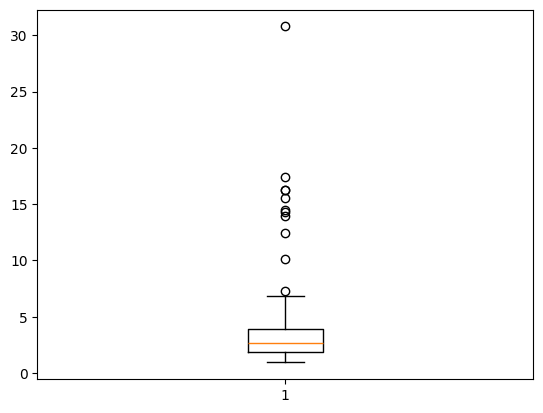

In [18]:
acceleration = np.array(stat['time_l']) / np.array(stat['time_h'])
plt.boxplot(acceleration)